Install this stuff first:

```
install.packages("scrm")
install.packages("https://github.com/YingZhou001/popdemog/raw/master/POPdemog_1.1.tar.gz", repos=NULL)
install.packages("tidyverse")
install.packages("glue")
```

In [1]:
library(scrm)
library(POPdemog)
library(tidyverse)
library(glue)
library(data.table)
library(microbenchmark)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



### Set the coalescent parameters

In [2]:
scale_time <- function(t) { t / gen_time / (4 * Ne0) }
scale_Ne <- function(Ne) { Ne / Ne0 }
scale_migr <- function(m) { 4 * m * Ne0 }

In [3]:
# generation time
gen_time <- 25

# effective population size used for scaling below
Ne0 <- 10000

# how old are the sampled Neanderthal haplotypes?
T_nea_age <- 70000

# how many haplotypes to sample from each population?
n_afr <- 200
n_eur <- 50
n_asn <- 50
n_nea <- 6
n_chimp <- 1

n_haplotypes <- 120000
hap_length <- 5001

# split between Homo and Chimp
T_chimp_split <- 6000000
# split between MH and Neanderthals
T_nea_mh_split <- 600000
# African/non-African split and bottleneck
T_afr_nonafr_split <- 60000

# Ne during the Out of Africa bottleneck
Ne_bottleneck <- 2000

# size of the Neanderthal population
Ne_nea <- 1000

# size of the ancestral population
Ne_anc <- 10000

Ne_afr <- 10000

# EUR <-> AFR migration rates
# m_afr_bottle <- 15e-5
m_afr_eur <- 5e-5
T_m_afr_eur <- 15000

# Neanderthal introgression parameters
T_nea_admix_start <- 55000
T_nea_admix_end <- T_nea_admix_start - 1000
m_nea_admix <- 0.00075

# mutation rate per site per generation
mut_rate <- 2.5e-8
# probability of cross-over between adjacent bases per generation 
recomb_rate <- 1e-8

# population scaled mutation and recombination rates
theta <- 4 * Ne0 * mut_rate * hap_length
rho <- 4 * Ne0 * recomb_rate * hap_length

Total admixture proportion:

In [4]:
m_nea_admix * (T_nea_admix_start - T_nea_admix_end) / gen_time

[1] 0.03

Total amount of simulated sequence:

In [5]:
n_haplotypes * hap_length / 1e6

[1] 600.12

Generate the command line options for time-sampling (4 Neanderthal haplotypes at 70ky ago and a single EMH haplotype at different time points specified from the Ice Age paper):

In [6]:
emh_ages <- read_delim("../data/emh_ages.txt", col_types="ci", col_names=c("name", "age"), delim=" ") %>%
    filter(name != "Oase1") %>%
    mutate(name=paste0("emh_", 1:nrow(.)))

In [7]:
ages <- bind_rows(emh_ages, tibble(name=paste0("eur_", 1:n_eur), age=0)) # add the "fake" present-day Europeans

In [8]:
eI <- c(
  glue("-eI {scale_time(T_nea_age)}             0        0       0       {n_nea}        0"), # Neanderthals
  glue("-eI {map_dbl(emh_ages$age, scale_time)} 0        1       0       0              0"), # EMHs
  glue("-eI 0                                   {n_afr}  0       0       0              0"), # present-day Africans
  glue("-eI 0                                   0        {n_eur} 0       0              0"), # present-day Europeans
  glue("-eI 0                                   0        0       {n_asn} 0              0"), # present-day Asians
  glue("-eI 0                                   0        0       0       0      {n_chimp}")  # present-day chimp
) %>%
  paste(collapse=" ")

### Compose the `scrm` command line string

In [9]:
scrm_cmd <- glue(

"{n_nea + n_afr + n_eur + n_asn + nrow(emh_ages) + n_chimp} {n_haplotypes} \\
-I 5 0 0 0 0 0 \\
-r {rho} {hap_length} \\
-t {theta} \\
-n 4 {scale_Ne(Ne_nea)} \\
-n 1 {scale_Ne(Ne_afr)}

-em {scale_time(T_nea_admix_end)} 2 4 {scale_migr(m_nea_admix)} \\
-em {scale_time(T_nea_admix_start)} 2 4 0 \\
-en {scale_time(T_nea_admix_start)} 2 {scale_Ne(Ne_bottleneck)} \\
-en {scale_time(T_afr_nonafr_split)} 1 {scale_Ne(Ne_anc)} \\

-em 0 1 2 {scale_migr(m_afr_eur)} \\
-em {scale_time(T_m_afr_eur)} 1 2 0 \\

-ej {scale_time(30000)} 3 2 \\
-ej {scale_time(T_afr_nonafr_split)} 2 1 \\
-ej {scale_time(T_nea_mh_split)} 4 1 \\
-ej {scale_time(T_chimp_split)} 5 1 \\

{eI}"

) %>% str_replace_all("\n", " ") %>% str_replace_all("  +", " ")

### Check that the demographic model looks reasonable

There are  8 time events for  5  populations
read N and g, done!
read m, done!
read pos and update, done!
demographic initiation, done!
plot initiation, done!


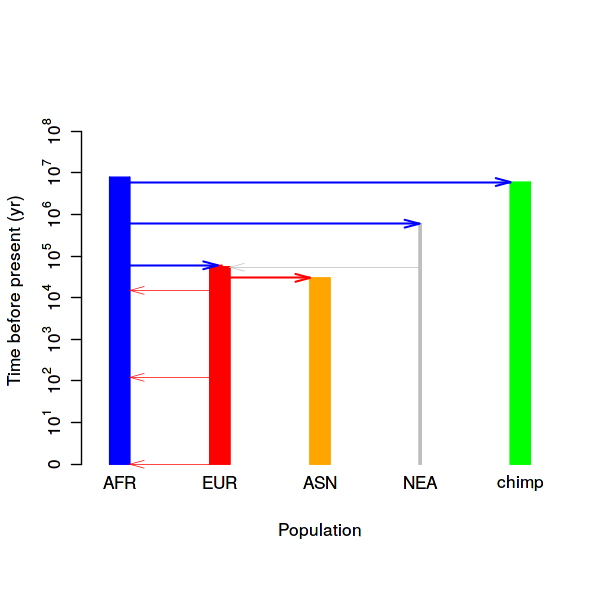

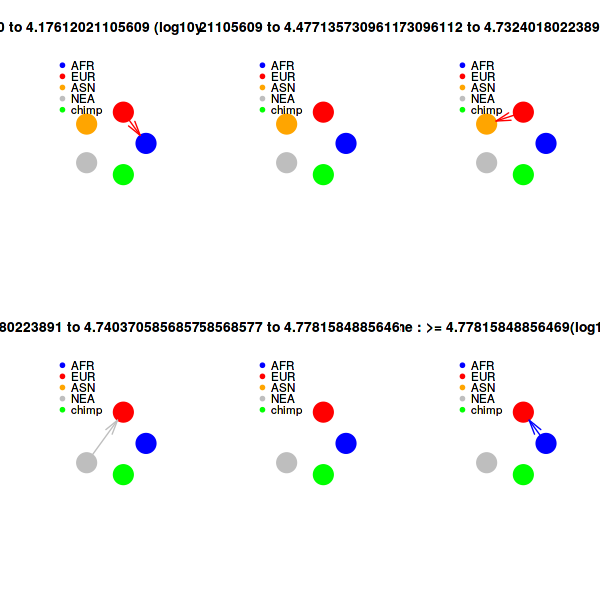

In [10]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res=100)

PlotMS(scrm_cmd, type="scrm",
       pops=c("AFR", "EUR", "ASN", "NEA", "chimp"),
       col.pop=c("blue", "red", "orange", "gray", "green"),
       time.scale="log10year", N4=4*Ne0,
       demo.out=TRUE) -> plot_out
PlotMMig(demograph_out=plot_out$demograph_out, mig_par=plot_out$mig_par)

### Run the simulation and extract the matrix with simulated haplotypes

In [11]:
run_cmd <- paste("scrm", scrm_cmd, "--transpose-segsites | tail -n+4 | grep '^[0-9]' | cut -d' ' -f3-")

In [12]:
# generate column names for the output df
col_names <- c(paste0("nea_", 1:n_nea),
               emh_ages$name,
               paste0("afr_", 1:n_afr),
               paste0("eur_", 1:n_eur),
               paste0("asn_", 1:n_eur),
               "chimp")

In [13]:
x <- microbenchmark(all_sites <- fread(run_cmd, col.names=col_names), times=1)

Read 13734975 rows and 357 (of 357) columns from 9.133 GB file in 00:01:44


In [14]:
print(x)

Unit: seconds
                                               expr      min       lq     mean
 all_sites <- fread(run_cmd, col.names = col_names) 869.7898 869.7898 869.7898
   median       uq      max neval
 869.7898 869.7898 869.7898     1


In [15]:
nrow(all_sites)

[1] 13734975

## Design the archaic admixture array
Keep only those sites that are nearly fixed in Africans, and fixed for a different allele in the Neanderthals (ignore the derived/ancestral state).

**To make testing easier, I'm requiring the African allele to be fixed! This can be changed later.**

In [16]:
# the lowest frequency of an allele allowed in the African population
afr_cutoff <- 1.0

In [17]:
calc_freq <- function(dt, pop) {
  dt[, rowSums(.SD) / length(.SD), .SDcols=colnames(dt)[str_detect(colnames(dt), pop)]]
}

In [18]:
afr_freq <- calc_freq(all_sites, "afr")
nea_freq <- calc_freq(all_sites, "nea")

In [19]:
admix_array <- all_sites[(afr_freq == 0 | afr_freq >= afr_cutoff) &
                         (nea_freq == 0 | nea_freq == 1) &
                         (abs(afr_freq - nea_freq) > 0.5)]

In [20]:
nrow(admix_array)

[1] 582907

What are the observed site patterns in Africans and Neanderthals? There should be only two:

In [21]:
distinct(select(admix_array, starts_with("afr"), starts_with("nea"))) %>% nrow

[1] 2

## Design the "Big Yoruba" array

Select 4 African haplotypes and 2 Neanderthal haplotypes and keep sites that are heterozygous in either of them (Big Yoruba array was designed on hets in 2 YRI males and hets in Altai).

In [22]:
bigyri_array <- all_sites[(nea_1 != nea_2) | (afr_1 != afr_2) | (afr_3 != afr_4)]

In [23]:
nrow(bigyri_array)

[1] 1064665

### Detect Neanderthal introgressed alleles in all simulated haplotypes

Detect all Neanderthal alleles in the non-African population (TRUE/FALSE at each site converted to integers - 1 is Nea-like allele, 0 is an African-like MH allele):

In [24]:
nea_states <- map_df(admix_array, ~ as.integer(. == admix_array$nea_1))

What are the leves of Nea. ancestry in non-African haplotypes?

In [25]:
nea_ancestry <- function(df, pop) {
    select(df, starts_with(pop)) %>% summarise_all(mean)
}

### Check the SFS of introgressed alleles in present-day Europeans

### Plot the simulated Nea. ancestry over time

In [26]:
f4 <- function(df, w, x, y, z) {
    sum((df[[w]] - df[[x]]) * (df[[y]] - df[[z]]))
}

f4_ratio <- function(df, x, a, b, c, o) {
    f4(df, a, o, x, c) / f4(df, a, o, b, c)
}

In [27]:
f4 <- function(df, w, x, y, z) {
  a <- df[, rowMeans(.SD), .SDcols=w]
  b <- df[, rowMeans(.SD), .SDcols=x]
  c <- df[, rowMeans(.SD), .SDcols=y]
  d <- df[, rowMeans(.SD), .SDcols=z]
  sum((a - b) * (c - d))
}

f4_ratio <- function(df, x, a, b, c, o) {
    f4(df, a, o, x, c) / f4(df, a, o, b, c)
}

Nea. ancestry using "direct" calculation on admixture array sites:

In [28]:
admix_nea <- bind_cols(nea_ancestry(nea_states, "emh"), nea_ancestry(nea_states, "eur")) %>%
    gather(name, nea) %>% mutate(method="'admixture array' Neanderthal proportion")

In [29]:
bigyri_nea <- tibble(name=c(emh_ages$name, paste0("eur_", 1:n_eur))) %>%
    mutate(nea=map_dbl(name, ~ f4_ratio(bigyri_array, x=., a=c("nea_3", "nea_4"), b=c("nea_5", "nea_6"),
                                        c=paste0("afr_", 5:10), o="chimp")),
           method="'Big Yoruba array' f4 ratio Neanderthal proportion")

In [30]:
all_nea <- tibble(name=c(emh_ages$name, paste0("eur_", 1:n_eur))) %>%
    mutate(nea=map_dbl(name, ~ f4_ratio(all_sites, x=., a=c("nea_3", "nea_4"), b=c("nea_5", "nea_6"),
                                        c=paste0("afr_", 5:10), o="chimp")),
           method="'All sites' f4 ratio Neanderthal proportion")

In [31]:
eur_to_afr_flow <- bind_rows(admix_nea, bigyri_nea, all_nea) %>% inner_join(ages)

Joining, by = "name"


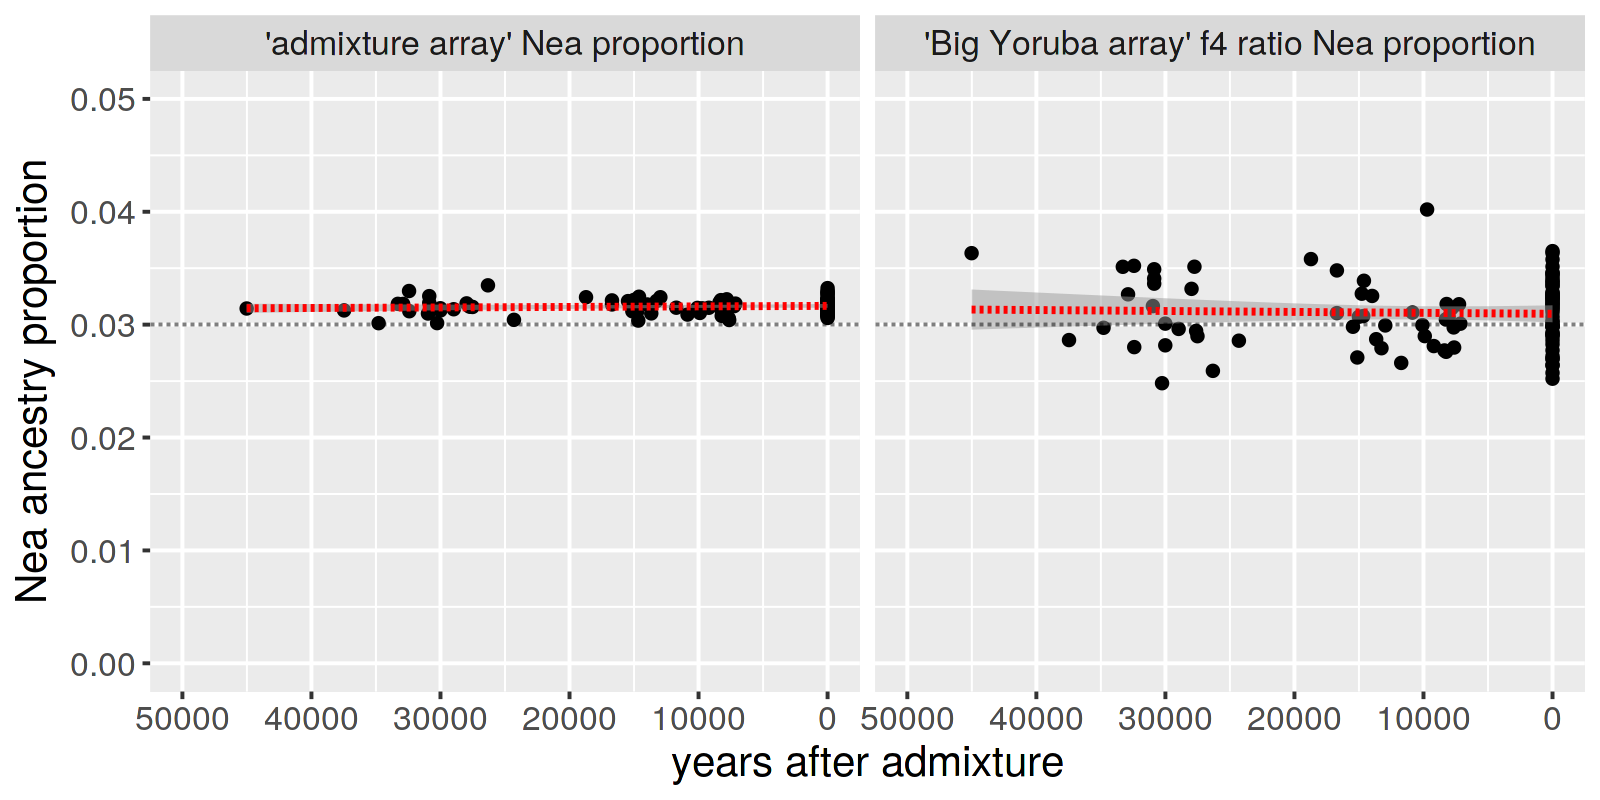

In [50]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res=200)

no_flow %>% mutate(method=str_replace(method, "Neanderthal", "Nea")) %>%
ggplot(aes(age, nea)) +
    geom_point() + xlim(50000, 0) + ylim(0, 0.05) +
    geom_smooth(method="lm", linetype=2, color="red", alpha=1/2) +
    geom_hline(yintercept=m_nea_admix * (T_nea_admix_start - T_nea_admix_end) / gen_time, linetype=2, alpha=1/2) +
    xlab("years after admixture") + ylab("Nea ancestry proportion") +
    facet_grid(. ~ method) + theme(text=element_text(size=15))

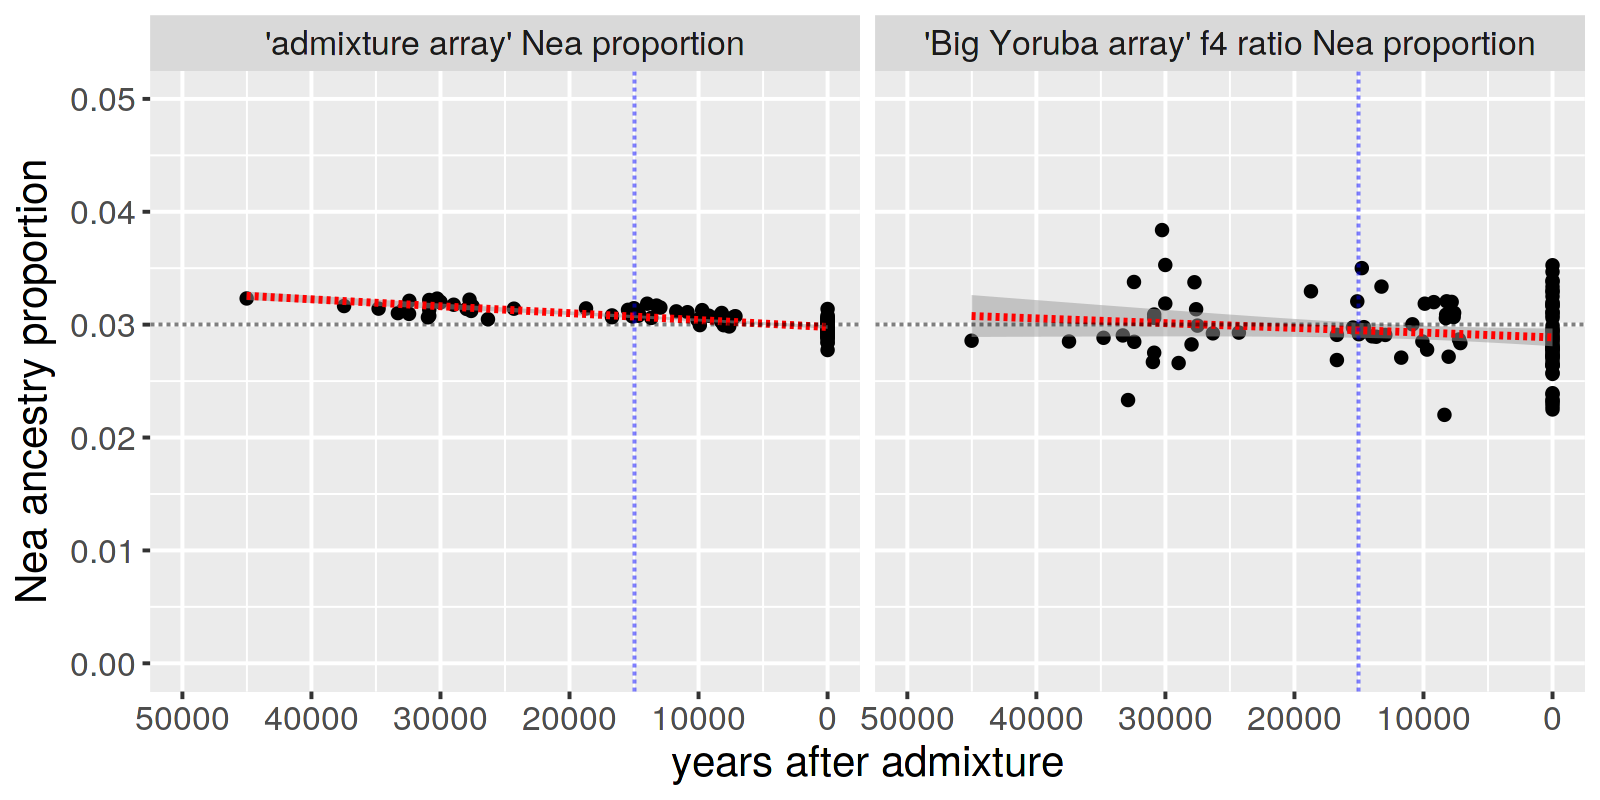

In [51]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res=200)

afr_to_eur_flow %>% mutate(method=str_replace(method, "Neanderthal", "Nea")) %>%
ggplot(aes(age, nea)) +
    geom_point() + xlim(50000, 0) + ylim(0, 0.05) +
    geom_smooth(method="lm", linetype=2, color="red", alpha=1/2) +
    geom_hline(yintercept=m_nea_admix * (T_nea_admix_start - T_nea_admix_end) / gen_time, linetype=2, alpha=1/2) +
    xlab("years after admixture") + ylab("Nea ancestry proportion") +
    geom_vline(xintercept=15000, linetype=2, color="blue", alpha=1/2) +
    facet_grid(. ~ method) + theme(text=element_text(size=15))

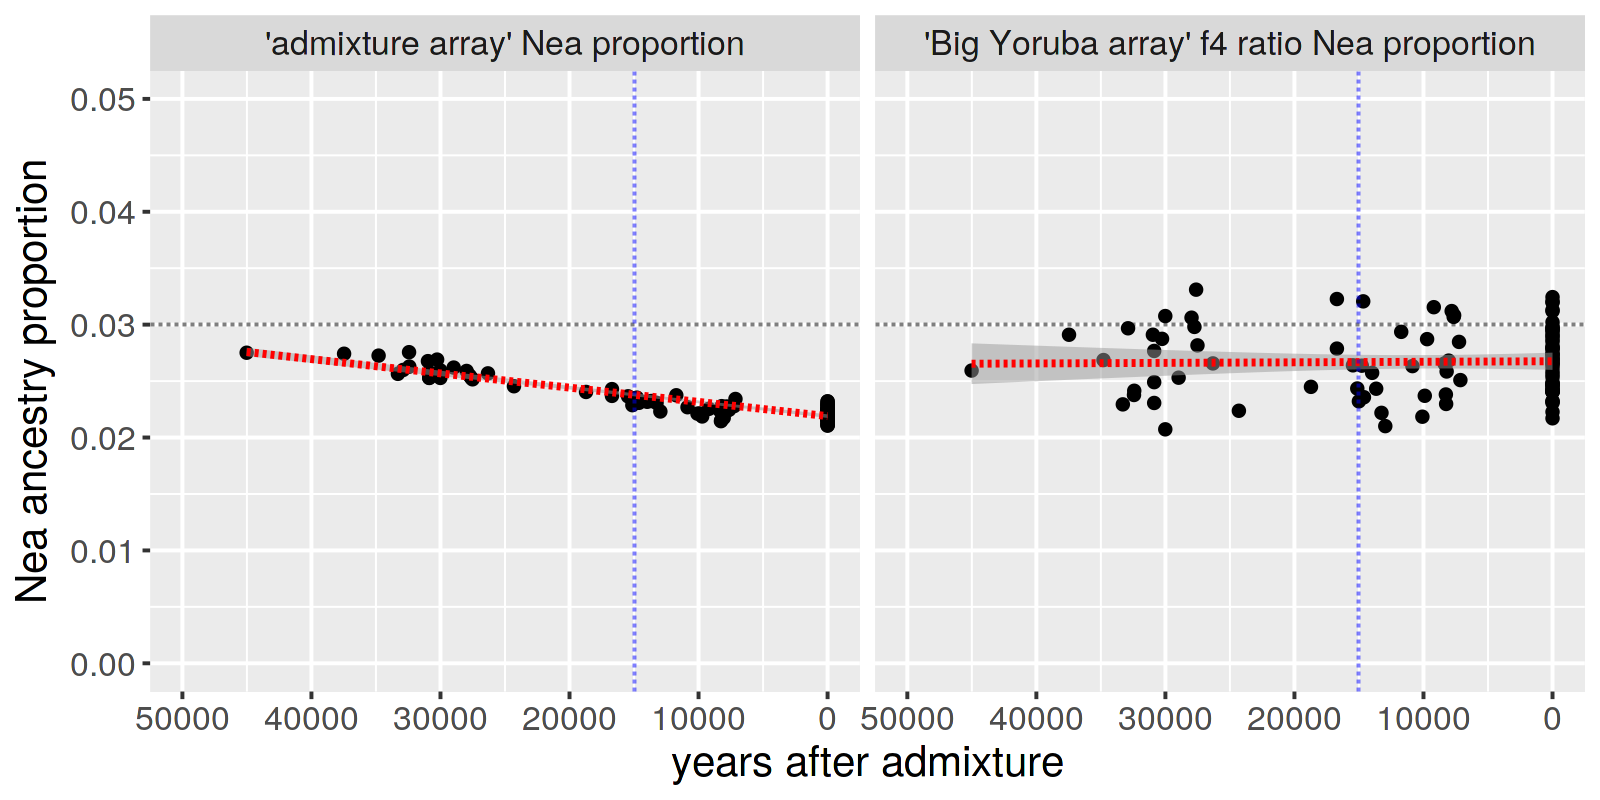

In [52]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res=200)

eur_to_afr_flow %>% mutate(method=str_replace(method, "Neanderthal", "Nea")) %>%
ggplot(aes(age, nea)) +
    geom_point() + xlim(50000, 0) + ylim(0, 0.05) +
    geom_smooth(method="lm", linetype=2, color="red", alpha=1/2) +
    geom_hline(yintercept=m_nea_admix * (T_nea_admix_start - T_nea_admix_end) / gen_time, linetype=2, alpha=1/2) +
    xlab("years after admixture") + ylab("Nea ancestry proportion") +
    geom_vline(xintercept=15000, linetype=2, color="blue", alpha=1/2) +
    facet_grid(. ~ method) + theme(text=element_text(size=15))

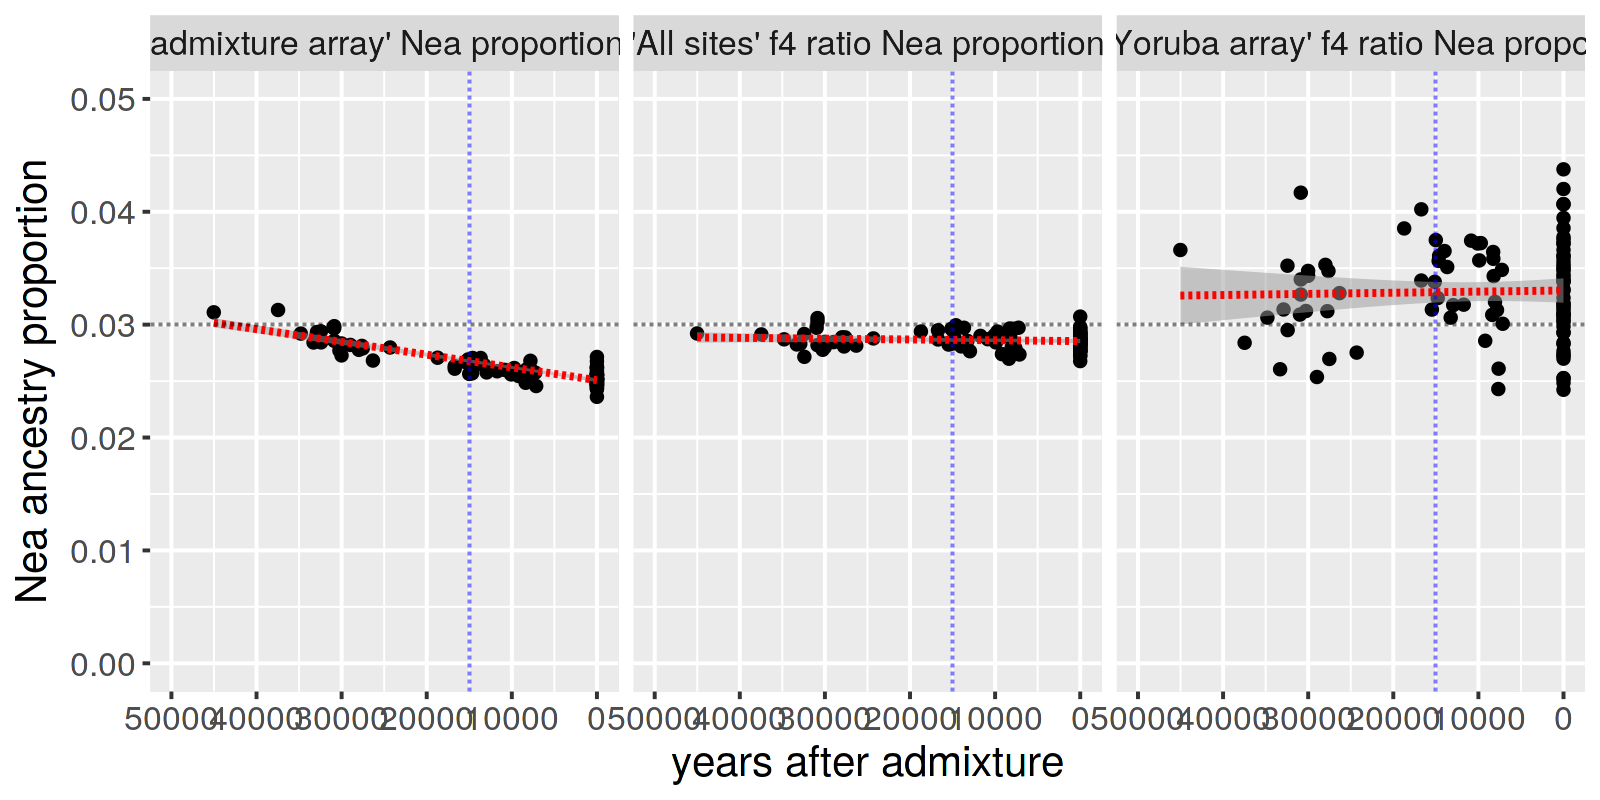

In [32]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res=200)

eur_to_afr_flow %>% mutate(method=str_replace(method, "Neanderthal", "Nea")) %>%
ggplot(aes(age, nea)) +
    geom_point() + xlim(50000, 0) + ylim(0, 0.05) +
    geom_smooth(method="lm", linetype=2, color="red", alpha=1/2) +
    geom_hline(yintercept=m_nea_admix * (T_nea_admix_start - T_nea_admix_end) / gen_time, linetype=2, alpha=1/2) +
    xlab("years after admixture") + ylab("Nea ancestry proportion") +
    geom_vline(xintercept=15000, linetype=2, color="blue", alpha=1/2) +
    facet_grid(. ~ method) + theme(text=element_text(size=15))

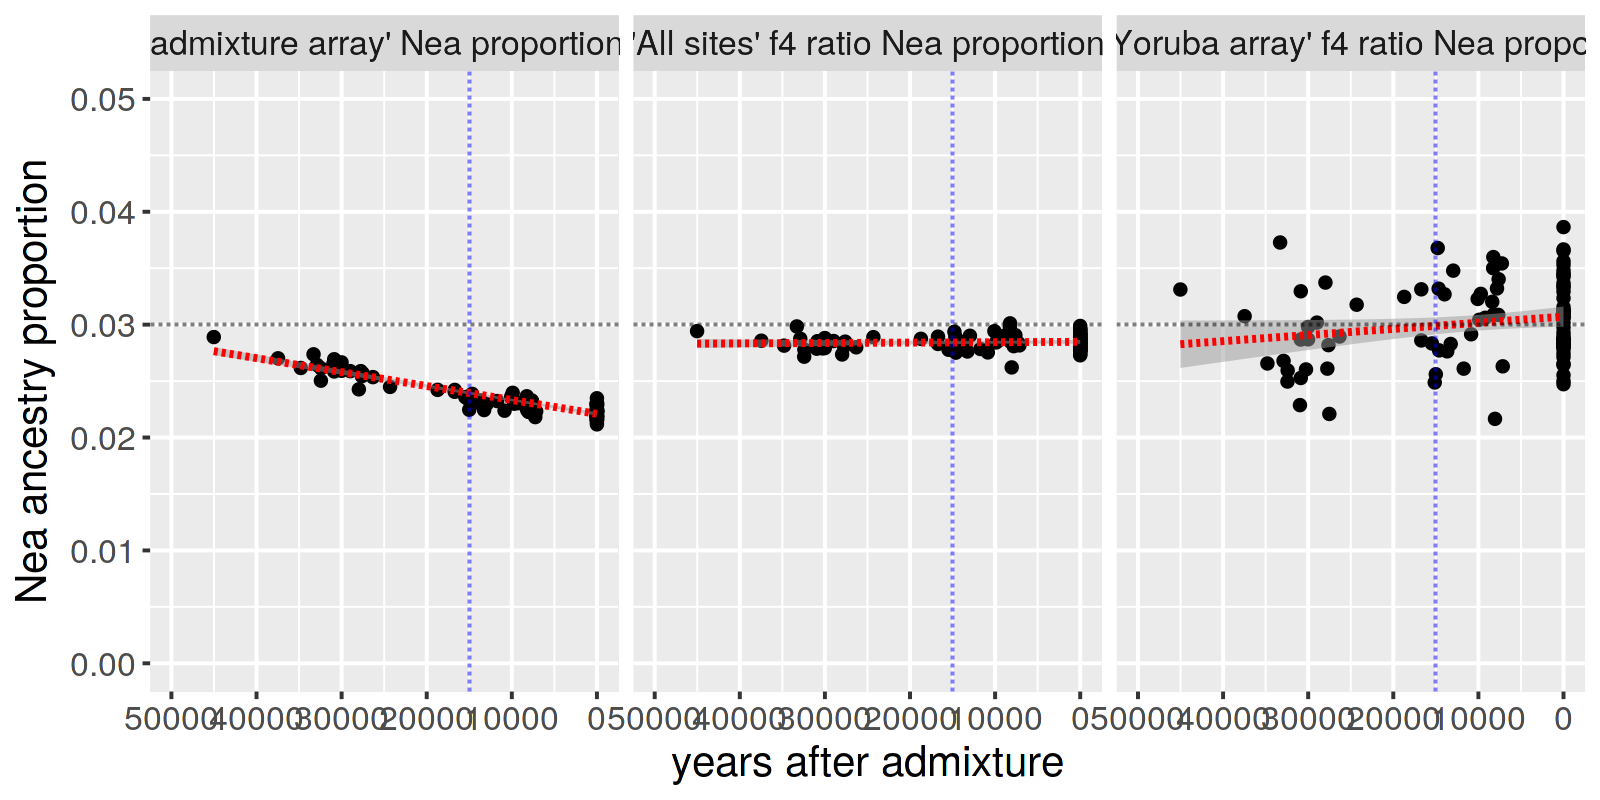

In [32]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res=200)

eur_to_afr_flow %>% mutate(method=str_replace(method, "Neanderthal", "Nea")) %>%
ggplot(aes(age, nea)) +
    geom_point() + xlim(50000, 0) + ylim(0, 0.05) +
    geom_smooth(method="lm", linetype=2, color="red", alpha=1/2) +
    geom_hline(yintercept=m_nea_admix * (T_nea_admix_start - T_nea_admix_end) / gen_time, linetype=2, alpha=1/2) +
    xlab("years after admixture") + ylab("Nea ancestry proportion") +
    geom_vline(xintercept=15000, linetype=2, color="blue", alpha=1/2) +
    facet_grid(. ~ method) + theme(text=element_text(size=15))

In [121]:
save.image("../data/RData/scrm_ascertainment-datatable.RData")

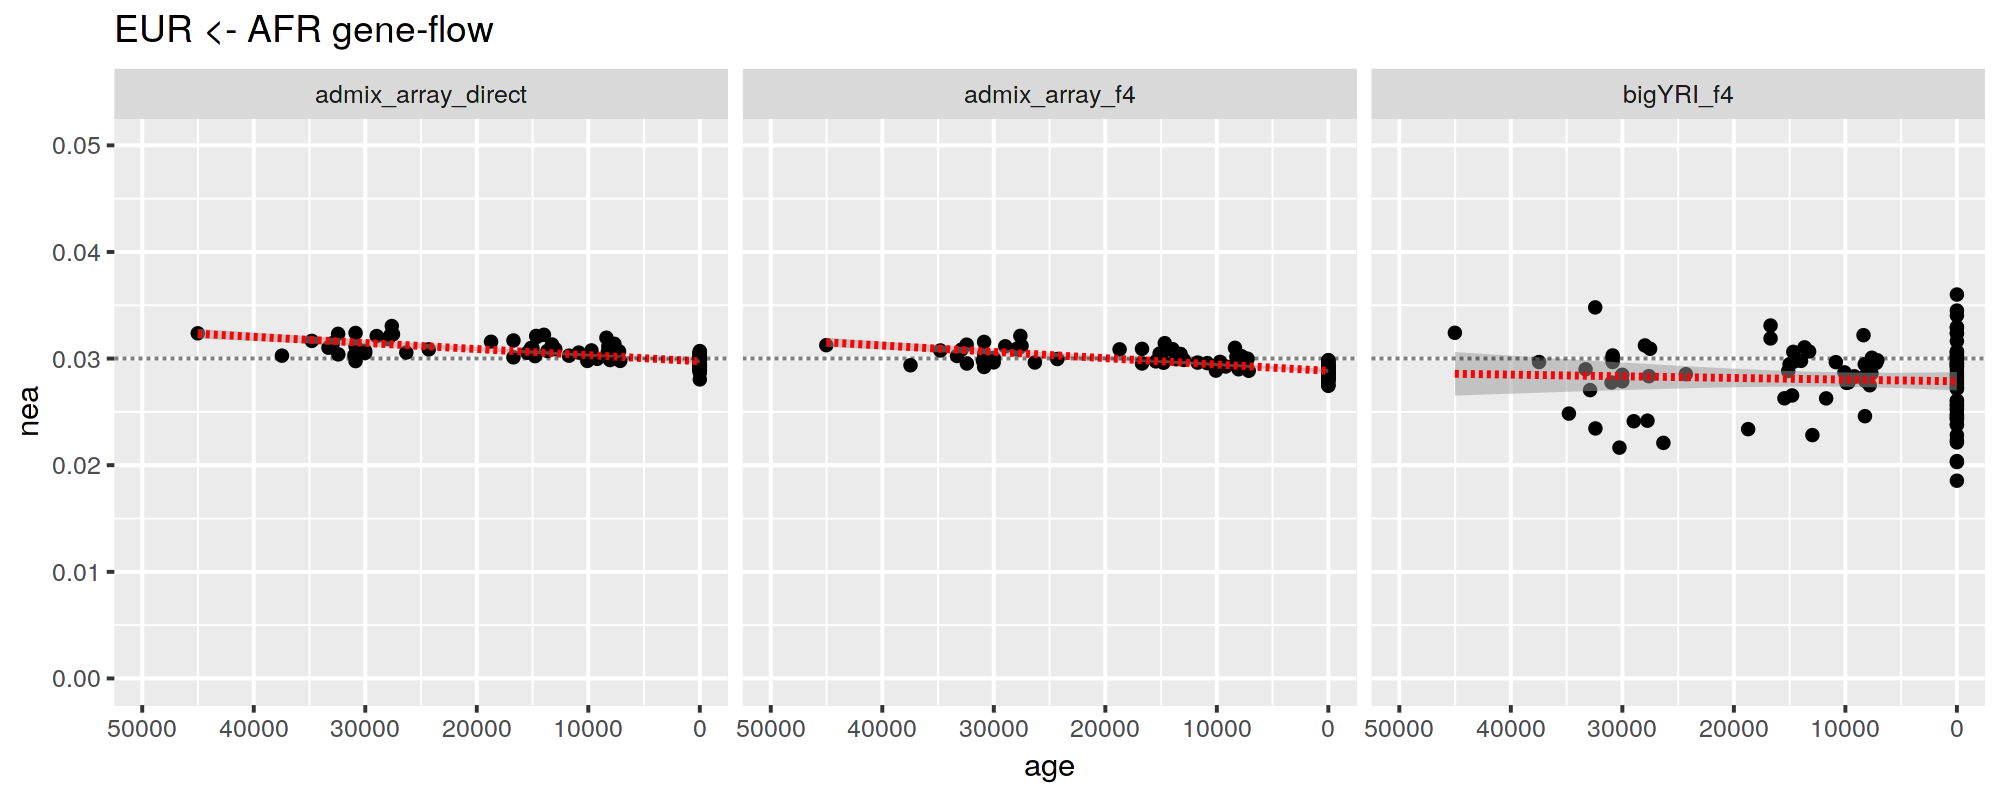

In [34]:
ggplot(nea_est, aes(age, nea)) +
    geom_point() + xlim(50000, 0) + ylim(0, 0.05) +
    geom_smooth(method="lm", linetype=2, color="red", alpha=1/2) +
    geom_hline(yintercept=m_nea_admix * (T_nea_admix_start - T_nea_admix_end) / gen_time, linetype=2, alpha=1/2) +
    facet_grid(. ~ method) +
    ggtitle(paste("EUR <- AFR gene-flow"))

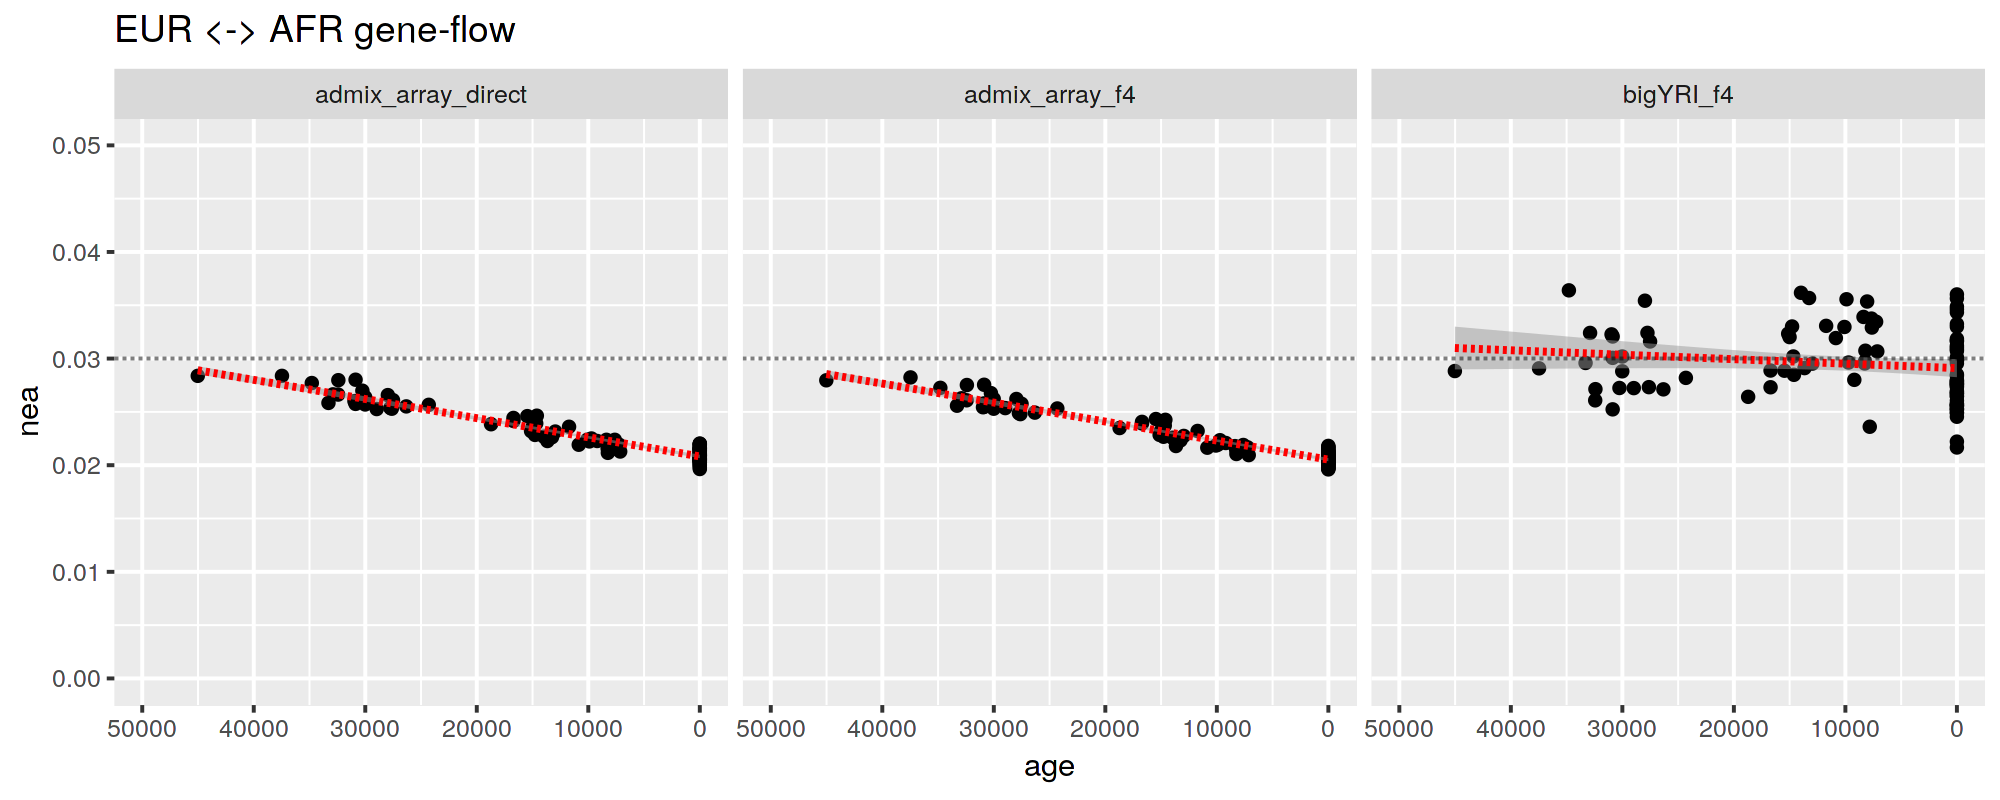

In [35]:
ggplot(nea_est, aes(age, nea)) +
    geom_point() + xlim(50000, 0) + ylim(0, 0.05) +
    geom_smooth(method="lm", linetype=2, color="red", alpha=1/2) +
    geom_hline(yintercept=m_nea_admix * (T_nea_admix_start - T_nea_admix_end) / gen_time, linetype=2, alpha=1/2) +
    facet_grid(. ~ method) +
    ggtitle(paste("EUR <-> AFR gene-flow"))

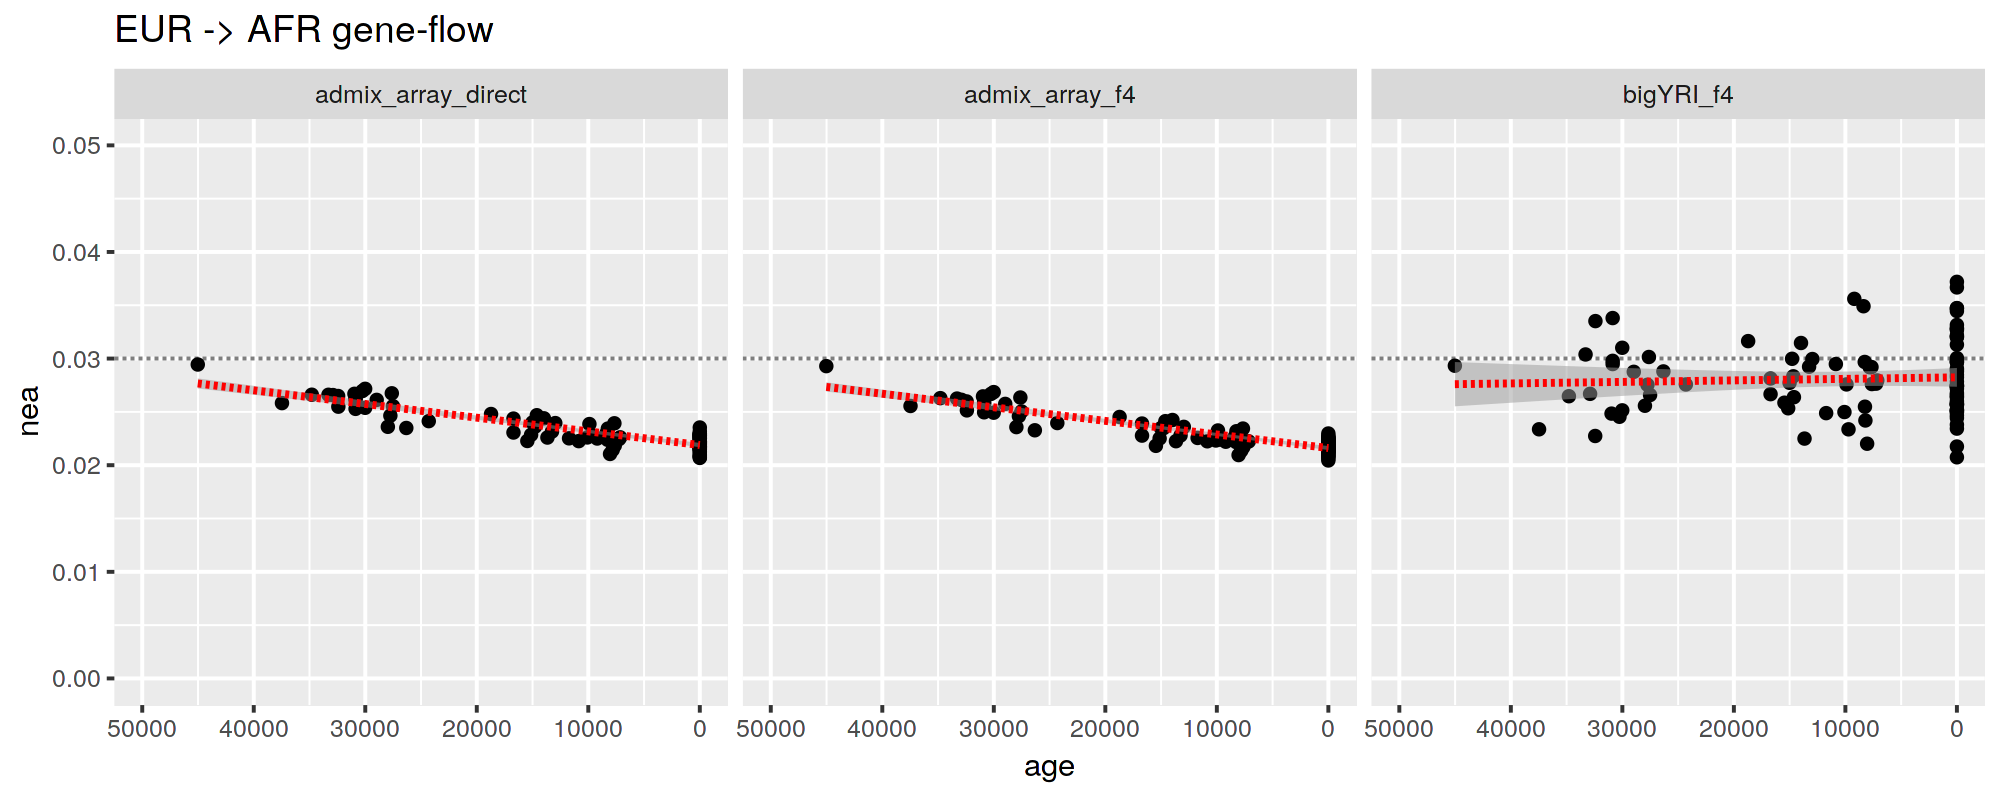

In [35]:
ggplot(nea_est, aes(age, nea)) +
    geom_point() + xlim(50000, 0) + ylim(0, 0.05) +
    geom_smooth(method="lm", linetype=2, color="red", alpha=1/2) +
    geom_hline(yintercept=m_nea_admix * (T_nea_admix_start - T_nea_admix_end) / gen_time, linetype=2, alpha=1/2) +
    facet_grid(. ~ method) +
    ggtitle(paste("EUR -> AFR gene-flow"))

## Admixture array simulation

In [45]:
options(repr.plot.width=10, repr.plot.height=5)

In [46]:
eur_vs_asn_aa <- data.frame(
    eur=nea_ancestry(nea_states, "eur") %>% t %>% as.vector,
    asn=nea_ancestry(nea_states, "asn") %>% t %>% as.vector
) %>% mutate(stat="admix_array_prop")

In [49]:
eur_vs_asn_yri <- data.frame(
    eur=map_dbl(paste0("eur_", 1:n_eur), ~ f4_ratio(bigyri_array, x=., a=c("nea_3", "nea_4"), b=c("nea_5", "nea_6"),
                                                                  c=paste0("afr_", 5:10), o="chimp")),
    asn=map_dbl(paste0("asn_", 1:n_asn), ~ f4_ratio(bigyri_array, x=., a=c("nea_3", "nea_4"), b=c("nea_5", "nea_6"),
                                                                  c=paste0("afr_", 5:10), o="chimp"))
) %>% mutate(stat="f4_big_YRI")

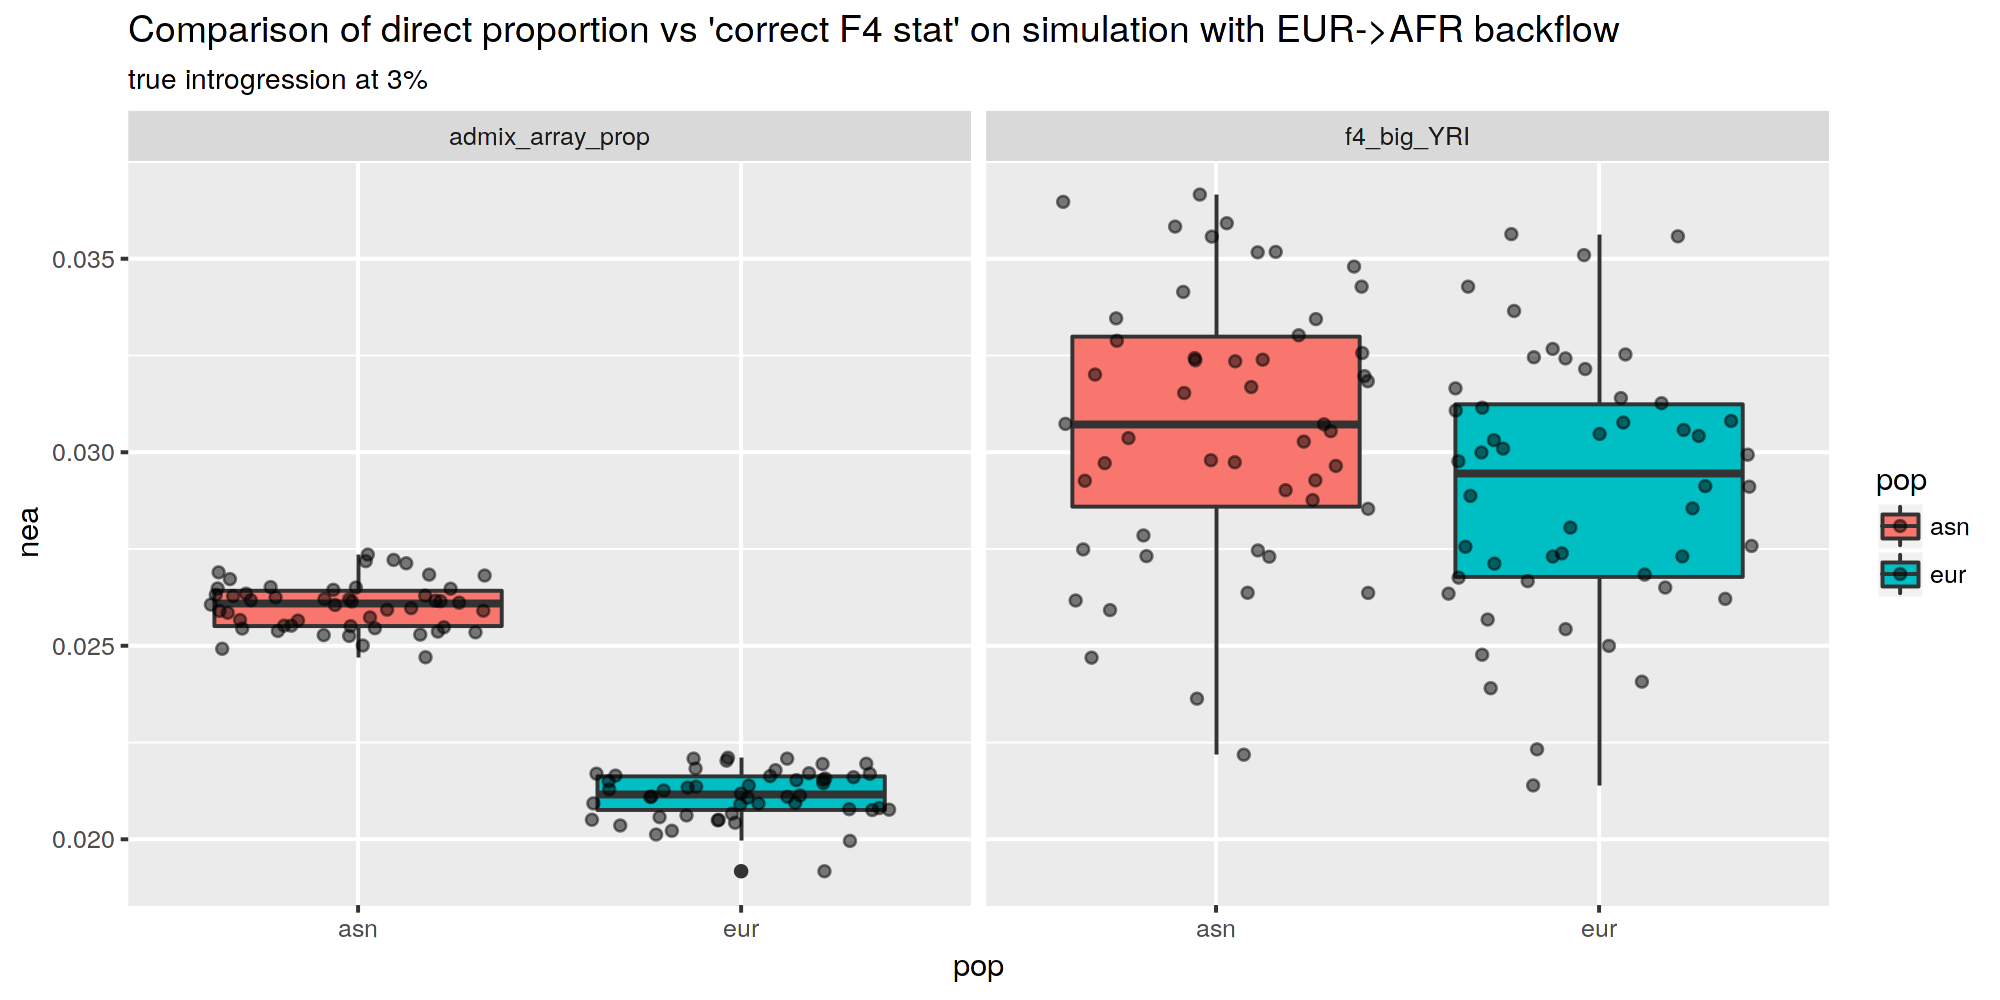

In [48]:
bind_rows(eur_vs_asn_aa, eur_vs_asn_yri) %>%
    gather(pop, nea, -stat) %>%
    ggplot(aes(pop, nea, fill=pop)) + geom_boxplot() + geom_jitter(alpha=1/2) + facet_grid(. ~ stat) +
    ggtitle("Comparison of direct proportion vs 'correct F4 stat' on simulation with EUR->AFR backflow",
            "true introgression at 3%")

In [1]:
suppressPackageStartupMessages({

library(scrm)
library(tidyverse)
library(glue)
library(data.table)
library(parallel)

})

### Set the coalescent parameters

In [2]:
scale_time <- function(t) { t / gen_time / (4 * Ne0) }
scale_Ne <- function(Ne, fac) { Ne / Ne0 * fac}
scale_migr <- function(m) { 4 * m * Ne0 }

In [3]:
# generation time
gen_time <- 25

# effective population size used for scaling below
Ne0 <- 20000

# how old are the sampled Neanderthal haplotypes?
T_nea_age <- 70000

# how many haplotypes to sample from each population?
n_afr <- 200
n_eur <- 50
n_asn <- 50
n_nea <- 6
n_chimp <- 1

n_haplotypes <- 100000
hap_length <- 5001

# split between Homo and Chimp
T_chimp_split <- 6000000
# split between MH and Neanderthals
T_nea_mh_split <- 800000
# African/non-African split and bottleneck
T_afr_nonafr_split <- 70000

# Ne during the Out of Africa bottleneck
Ne_bottleneck <- 2000

# size of the Neanderthal population
Ne_nea <- 1000

# size of the ancestral population
Ne_anc <- 10000

# EUR <-> AFR migration rates
# m_afr_bottle <- 15e-5
m_afr_eur <- 1e-4 # 2.5e-5
T_m_afr_eur <- 15000

# Neanderthal introgression parameters
T_nea_admix_start <- 55000
T_nea_admix_end <- T_nea_admix_start - 1000
m_nea_admix <- 0.00075

# mutation rate per site per generation
mut_rate <- 2.5e-8
# probability of cross-over between adjacent bases per generation 
recomb_rate <- 1e-8

# population scaled mutation and recombination rates
theta <- 4 * Ne0 * mut_rate * hap_length
rho <- 4 * Ne0 * recomb_rate * hap_length

In [4]:
eI <- c(
  glue("-eI {scale_time(T_nea_age)}             0        0       0       {n_nea}        0"), # Neanderthals
  glue("-eI 0                                   0        0       0       0              0"), # EMHs
  glue("-eI 0                                   {n_afr}  0       0       0              0"), # present-day Africans
  glue("-eI 0                                   0        {n_eur} 0       0              0"), # present-day Europeans
  glue("-eI 0                                   0        0       0       0              0"), # present-day Asians
  glue("-eI 0                                   0        0       0       0              0")  # present-day chimp
) %>%
  paste(collapse=" ")

In [5]:
(scaling_factors <- seq(0.25, 1, length.out=4))

[1] 0.25 0.50 0.75 1.00

In [6]:
calc_freq <- function(dt, pop) {
  dt[, rowSums(.SD) / length(.SD), .SDcols=colnames(dt)[str_detect(colnames(dt), pop)]]
}

In [7]:
nea_ancestry <- function(df, pop) {
    select(df, starts_with(pop)) %>% summarise_all(mean)
}

In [32]:
bins <- mclapply(mc.cores=length(scaling_factors), scaling_factors, function(x) {
    
scrm_cmd <- glue(

"{n_nea + n_afr + n_eur} {n_haplotypes} \\
-I 5 0 0 0 0 0 \\
-r {rho} {hap_length} \\
-t {theta} \\
-n 4 {scale_Ne(Ne_nea, x)} \\

-em {scale_time(T_nea_admix_end)} 2 4 {scale_migr(m_nea_admix)} \\
-em {scale_time(T_nea_admix_start)} 2 4 0 \\
-en {scale_time(T_nea_admix_start)} 2 {scale_Ne(Ne_bottleneck, x)} \\

-em 0 1 2 {scale_migr(m_afr_eur)} \\
-em {scale_time(T_m_afr_eur)} 1 2 0 \\

-ej {scale_time(30000)} 3 2 \\
-ej {scale_time(T_afr_nonafr_split)} 2 1 \\
-ej {scale_time(T_nea_mh_split)} 4 1 \\
-ej {scale_time(T_chimp_split)} 5 1 \\

{eI}"

) %>% str_replace_all("\n", " ") %>% str_replace_all("  +", " ")

run_cmd <- paste("scrm", scrm_cmd, "--transpose-segsites | tail -n+4 | grep '^[0-9]' | cut -d' ' -f3-")

# generate column names for the output df
col_names <- c(paste0("nea_", 1:n_nea),
               paste0("afr_", 1:n_afr),
               paste0("eur_", 1:n_eur))

all_sites <- fread(run_cmd, col.names=col_names)

# the lowest frequency of an allele allowed in the African population
afr_cutoff <- 1.0

afr_freq <- calc_freq(all_sites, "afr")
nea_freq <- calc_freq(all_sites, "nea")

admix_array <- all_sites[(afr_freq == 0 | afr_freq >= afr_cutoff) &
                         (nea_freq == 0 | nea_freq == 1) &
                         (abs(afr_freq - nea_freq) > 0.5)]

rm(all_sites)

nea_states <- map_df(admix_array, ~ as.integer(. == admix_array$nea_1))

tibble(
    nea=nea_ancestry(nea_states, "eur") %>% t %>% .[, 1],
    bin=x
)

}) %>% bind_rows